# Global Cyberattack Pattern Analysis — Data Mining (Anaconda Edition)

**Notebook:** 06_association_rules.ipynb — Apriori rules (Vendor/Product/CWE)

In [1]:

import sys, subprocess
try:
    import mlxtend  # noqa
except ImportError:
    subprocess.check_call([sys.executable, "-m", "pip", "install", "-q", "mlxtend"])

import pandas as pd
import numpy as np
from pathlib import Path
import joblib

from mlxtend.preprocessing import TransactionEncoder


ROOT = Path.cwd()
if ROOT.name == "notebooks":
    ROOT = ROOT.parent

METRICS_DIR = ROOT / "reports" / "metrics"
OUT_DIR = ROOT / "reports" / "association_rules"
OUT_DIR.mkdir(parents=True, exist_ok=True)

# Load the same features used in 03/04

splits = joblib.load(METRICS_DIR / "splits.joblib")
df = pd.concat([splits["X_train"], splits["X_test"]], axis=0).reset_index(drop=True)

# Normalize columns that might appear/not appear depending on KEV version

cat_cols = [c for c in ["vendorProject", "product", "cwe_primary"] if c in df.columns]
num_cols = [c for c in ["year_added", "month_added"] if c in df.columns]
bool_cols = [c for c in ["ransomware_known"] if c in df.columns]

# Simple value cleaning

for c in cat_cols:
    df[c] = df[c].fillna("Unknown").astype(str).str.strip()

if "year_added" in df:
    df["year_added"] = df["year_added"].fillna(-1).astype(int)
if "month_added" in df:
    df["month_added"] = df["month_added"].fillna(-1).astype(int)
if "ransomware_known" in df:
    df["ransomware_known"] = df["ransomware_known"].fillna(False).astype(bool)

# Optionally bucket numeric features to reduce sparsity (good for rules)

if "year_added" in df:
    df["year_bucket"] = pd.cut(df["year_added"],
                               bins=[2020, 2022, 2023, 2025, 2030],
                               labels=["<=2022", "2023", "2024-2025", ">=2026"],
                               right=True, include_lowest=True)
    cat_cols.append("year_bucket")
if "month_added" in df:
    df["month_bucket"] = pd.cut(df["month_added"],
                                bins=[-1, 3, 6, 9, 12],
                                labels=["Q1", "Q2", "Q3", "Q4"])
    cat_cols.append("month_bucket")

# Build transactions: each row -> list of tokens like "vendor=Microsoft", "cwe=CWE-79", ...

def make_items(row):
    items = []
    if "vendorProject" in row: items.append(f"vendor={row['vendorProject']}")
    if "product" in row:       items.append(f"product={row['product']}")
    if "cwe_primary" in row:   items.append(f"cwe={row['cwe_primary']}")
    if "year_bucket" in row:   items.append(f"year={row['year_bucket']}")
    if "month_bucket" in row:  items.append(f"month={row['month_bucket']}")
    if "ransomware_known" in row: items.append(f"ransomware={bool(row['ransomware_known'])}")
    return [str(x) for x in items if pd.notna(x) and str(x) != "nan"]

transactions = [make_items(r) for _, r in df.iterrows()]
print("Sample transaction:", transactions[0][:6])

# One-hot encode transactions for Apriori

te = TransactionEncoder()
te_ary = te.fit(transactions).transform(transactions)
ohe_df = pd.DataFrame(te_ary, columns=te.columns_)
ohe_df.iloc[:3, :10]


Sample transaction: ['vendor=Adobe', 'product=Flash Player and AIR', 'cwe=CWE-416', 'year=<=2022', 'month=Q2', 'ransomware=False']


,cwe=CWE-114,cwe=CWE-116,cwe=CWE-1173,cwe=CWE-1188,cwe=CWE-119,cwe=CWE-120,cwe=CWE-121,cwe=CWE-122,cwe=CWE-1220,cwe=CWE-123
0,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False


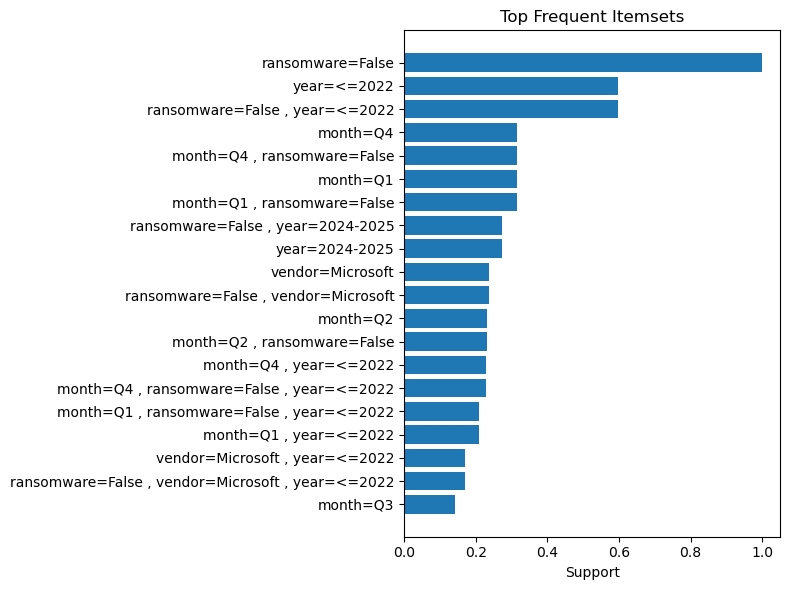

✅ Saved to: C:\Users\asus\Downloads\global_cyberattack_dm_anaconda\global_cyberattack_dm\reports\association_rules

Top 10 rules:


,antecedents,consequents,support,confidence,lift
0,"product=Chromium V8, ransomware=False",vendor=Google,0.025228,1.000000,21.953846
1,product=Chromium V8,"ransomware=False, vendor=Google",0.025228,1.000000,21.953846
2,product=Chromium V8,vendor=Google,0.025228,1.000000,21.953846
3,product=Flash Player,"vendor=Adobe, year=<=2022",0.020322,0.878788,21.254751
4,product=Flash Player,vendor=Adobe,0.023125,1.000000,19.026667
5,"product=Flash Player, ransomware=False",vendor=Adobe,0.023125,1.000000,19.026667
6,product=Flash Player,"ransomware=False, vendor=Adobe",0.023125,1.000000,19.026667
7,"product=Flash Player, year=<=2022",vendor=Adobe,0.020322,1.000000,19.026667
8,product=Multiple Products,vendor=Apple,0.031535,0.681818,11.582792
9,"product=Multiple Products, ransomware=False",vendor=Apple,0.031535,0.681818,11.582792



— Top rules involving Microsoft:


,antecedents,consequents,support,confidence,lift
11,"vendor=Microsoft, year=2024-2025",product=Windows,0.034338,0.690141,6.395006
27,"cwe=CWE-119, vendor=Microsoft",year=<=2022,0.023826,1.000000,1.676851
39,"product=Internet Explorer, vendor=Microsoft",year=<=2022,0.021023,0.882353,1.479574
51,"month=Q4, vendor=Microsoft",year=<=2022,0.057463,0.796117,1.334969
55,"cwe=Unknown, vendor=Microsoft",year=<=2022,0.032936,0.783333,1.313533
56,"month=Q2, vendor=Microsoft",year=<=2022,0.039944,0.770270,1.291628
60,"month=Q1, vendor=Microsoft",year=<=2022,0.064471,0.747967,1.254230
70,vendor=Microsoft,year=<=2022,0.168185,0.710059,1.190663
71,"ransomware=False, vendor=Microsoft",year=<=2022,0.168185,0.710059,1.190663
72,vendor=Microsoft,"ransomware=False, year=<=2022",0.168185,0.710059,1.190663



— Top rules involving CWE-20 (Input Validation):


,antecedents,consequents,support,confidence,lift
29,"cwe=CWE-20, month=Q4",year=<=2022,0.024527,0.945946,1.586210
46,"cwe=CWE-20, month=Q1",year=<=2022,0.026629,0.863636,1.448189
48,"cwe=CWE-20, ransomware=False",year=<=2022,0.065872,0.846847,1.420036
49,cwe=CWE-20,"ransomware=False, year=<=2022",0.065872,0.846847,1.420036
50,cwe=CWE-20,year=<=2022,0.065872,0.846847,1.420036



— Top rules predicting ransomware=True (if present):


,antecedents,consequents,support,confidence,lift


In [3]:


import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning, module="mlxtend")  # optional: silence benign warning

from mlxtend.frequent_patterns import apriori, association_rules
import matplotlib.pyplot as plt

# Tunable thresholds

MIN_SUPPORT   = 0.02     # try 0.03..0.05 to get fewer, stronger rules
MIN_CONF      = 0.60     # try 0.70
MIN_LIFT      = 1.10     # try 1.20
MAX_LEN       = 3

#  Frequent itemsets

freq = apriori(ohe_df, min_support=MIN_SUPPORT, use_colnames=True, max_len=MAX_LEN)
freq = freq.sort_values("support", ascending=False).reset_index(drop=True)
freq["length"] = freq["itemsets"].apply(len)

# Save and visualize frequent itemsets

freq_out = OUT_DIR / f"frequent_itemsets_s{MIN_SUPPORT}_len{MAX_LEN}.csv"
freq.to_csv(freq_out, index=False)

top_n = min(20, len(freq))
plt.figure(figsize=(8, 6))
plt.barh(range(top_n), freq["support"].head(top_n)[::-1])
plt.yticks(
    range(top_n),
    [" , ".join(sorted(list(s))) for s in freq["itemsets"].head(top_n)][::-1]
)
plt.xlabel("Support"); plt.title("Top Frequent Itemsets"); plt.tight_layout()
plt.savefig(OUT_DIR / "top_frequent_itemsets.png", dpi=220)
plt.show()

# Association rules

if len(freq) == 0:
    print("No frequent itemsets at this support. Increase MIN_SUPPORT or check data.")
    rules = pd.DataFrame()
else:
    rules = association_rules(freq, metric="confidence", min_threshold=MIN_CONF)
    # Keep only interesting rules
    rules = rules.sort_values(["lift","confidence","support"], ascending=False)
    rules = rules.query("lift >= @MIN_LIFT").reset_index(drop=True)

    # Make readable strings
    rules["antecedents"] = rules["antecedents"].apply(lambda s: ", ".join(sorted(list(s))))
    rules["consequents"] = rules["consequents"].apply(lambda s: ", ".join(sorted(list(s))))

# Save rules

rules_out = OUT_DIR / f"association_rules_s{MIN_SUPPORT}_c{MIN_CONF}_l{MIN_LIFT}.csv"
rules.to_csv(rules_out, index=False)

print("✅ Saved to:", OUT_DIR)
print("\nTop 10 rules:")
display(rules.head(10)[["antecedents","consequents","support","confidence","lift"]] if not rules.empty else rules)

# safe filter (regex=False to avoid issues in CWE codes)

def top_rules_about(prefix, col="antecedents", n=5):
    if rules.empty: 
        return rules
    mask = rules[col].str.contains(prefix, case=False, na=False, regex=False)
    return rules[mask][["antecedents","consequents","support","confidence","lift"]].head(n)

print("\n— Top rules involving Microsoft:")
display(top_rules_about("vendor=Microsoft", n=10))

print("\n— Top rules involving CWE-20 (Input Validation):")
df_cwe20 = top_rules_about("cwe=CWE-20", n=10)
if df_cwe20.empty:
    df_cwe20 = top_rules_about("CWE-20", n=10)  # fallback
display(df_cwe20)

print("\n— Top rules predicting ransomware=True (if present):")
if not rules.empty:
    mask_ransom = rules["consequents"].str.contains("ransomware=True", na=False, regex=False)
    display(rules[mask_ransom][["antecedents","consequents","support","confidence","lift"]].head(10))
